In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Found existing installation: pyafmreader x.x.x
Uninstalling pyafmreader-x.x.x:
  Successfully uninstalled pyafmreader-x.x.x
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-6p59fs_k
  Running command git clone --filter=blob:none --quiet https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-6p59fs_k
  Resolved https://github.com/jlopezalo/pyafmreader.git to commit 68b3a64249d775dabc52e3a611fefecabbdb72c5
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-qwn5svwp/fasterzip_e467420e95544cd6bf2b63b06a4c2b99
  Running command git clone --filter=blob:none --quiet https://github.com/TkTech/fasterzip.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-qwn5sv

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-qhc5lmt7
  Running command git clone --filter=blob:none --quiet https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-qhc5lmt7
  Resolved https://github.com/jlopezalo/pyafmrheo.git to commit f89842094bce872e7560b3bf71ab7833b230881d
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for pyafmrheo, since package 'wheel' is not installed.
  Running setup.py install for pyafmrheo ... done

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.routines.TingFit import doTingFit

In [21]:
# Define global variables
file_path = '/Users/javierlopez/Desktop/20221029/SFC/map-data-2022.10.29-12.27.34.564.jpk-force-map'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
tip_parameter = 5000* 1e-9 # meters
# Poisson ratio
poisson_ratio = 0.5
# Max non contact region
maxnoncontact = 1 * 1e-6
# Window to find cp
windowforCP = 400e-9
# Smooth window
smooth_w = 1
# t0 scaling factor
t0 = 1
# Viscous drag for PFQNM
vdrag = 0.0025 / 1e3
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)
pts_downsample = 300

In [22]:
file = loadfile(file_path)

In [23]:
filemetadata = file.filemetadata
print(filemetadata['file_type'])

.jpk-force-map


In [24]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [25]:
param_dict = {
    'compute_all_curves': False,
    'method': 'TingFit',
    'height_channel': 'measuredHeight',
    'def_sens': 1.4678505383171551e-08,
    'k': 0.191,
    'contact_model': 'paraboloid',
    'tip_param': 5e-06,
    'curve_seg': 'extend',
    'correct_tilt': False,
    'tilt_min_offset': 1e-08,
    'tilt_max_offset': 1e-06,
    'poisson': 0.5,
    'poc_win': 4e-07,
    'max_ind': 0.0,
    'min_ind': 0.0,
    'max_force': 0.0,
    'min_force': 0.0,
    'fit_range_type': 'full',
    'vdragcorr': False,
    'polyordr': 2,
    'rampspeed': 0.0,
    'compute_v_flag': False,
    't0': 1,
    'd0': 0.0,
    'slope': 0.0,
    'auto_init_E0': True,
    'E0': 1000,
    'tc': 0.0,
    'auto_init_betaE': True,
    'fluid_exp': 0.2,
    'f0': 0.0,
    'vdrag': 2.5e-06,
    'model_type': 'analytical',
    'smoothing_win': 5,
    'contact_offset': 1e-06,
    'fit_line': False, 
    'pts_downsample': 300
}

In [26]:
curve_idx = 0
force_curve = file.getcurve(curve_idx)
force_curve.preprocess_force_curve(param_dict['def_sens'], param_dict['height_channel'])
if filemetadata['file_type'] in ('.jpk-force', '.jpk-force-map', '.jpk-qi-data'):
    force_curve.shift_height()

In [27]:
ting_result, hertz_result = doTingFit(force_curve, param_dict)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyafmrheo/models/hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyafmrheo/models/ting.py:265: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(time, F, delta, t0, idx_tm, smooth_w, v0t, v0r)**2/F)


In [28]:
hertz_result.fit_report()


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 5e-06

        BEC Model: None

        Number of free parameters: 3

        delta0: 1.031270614024663e-07

        E0: 598.9265143160303

        f0: -2.5801908816798705e-11

        slope: None

        # Fit metrics
        MAE: 1.5617144984146664e-19

        MSE: 8.5064710644448e-22

        RMSE: 2.916585514680617e-11

        Rsq: 0.9606178607695809

        Chisq: 7.698124231973645e-08

        RedChisq: 2.5660414106578816e-08

        


In [29]:
ting_result.fit_report()


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 5e-06

        Model Format: analytical

        Viscous Drag: 2.5e-06

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 128

        Number of free parameters: 4

        E0: 283.23447214824364

        tc: 0.002061653592351868

        betaE: 0.19112523127718908

        F0: -5.295532130031678e-11

        # Fit metrics
        MAE: -2.6193435037005915e-19

        MSE: 1.3212322800743775e-21

        RMSE: 3.634875898946727e-11

        Rsq: 0.9736554434622132

        Chisq: -6.889896906159143e-10

        RedChisq: -1.7224742265397858e-10

        


In [30]:
segs = force_curve.get_segments()
ext_data = segs[0][1]
ret_data = segs[1][1]
idx_tc = (np.abs(ext_data.indentation - 0)).argmin()
t0 = ext_data.time[-1]
indentation = np.r_[ext_data.indentation, ret_data.indentation]
time = np.r_[ext_data.time, ret_data.time + t0]
force = np.r_[ext_data.force, ret_data.force]
fit_mask = indentation > (-1 * maxnoncontact)
tc = time[idx_tc]
ind_fit = indentation[fit_mask]
force_fit = force[fit_mask]
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
tc_fit = tc-time_fit[0]
time_fit = time_fit - time_fit[0] - tc_fit

downfactor= len(time_fit) // pts_downsample
idxDown = list(range(0, len(time_fit), downfactor))

In [56]:
idx_tc = (np.abs(time_fit[idxDown] - ting_result.tc)).argmin()
d0 = ind_fit[idxDown][idx_tc]
print(d0)

4.800349237605782e-08


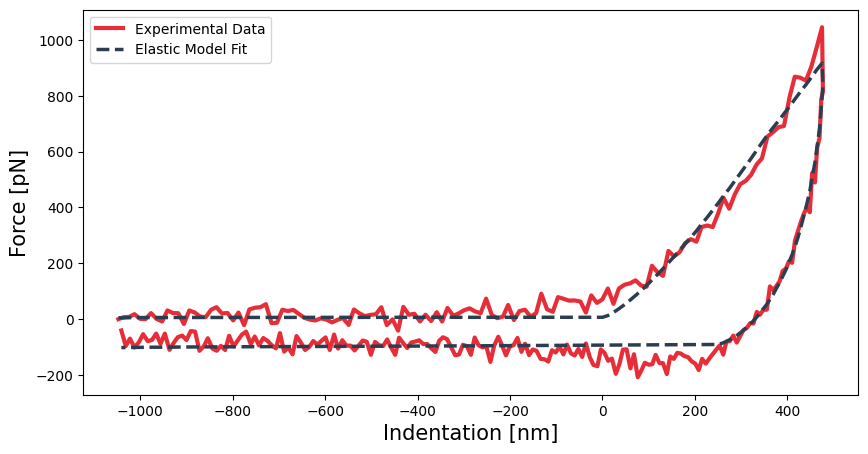

In [58]:
plt.plot(
    (ind_fit[idxDown] - d0) * 1e9,
    force_fit[idxDown] * 1e12,
    color='#E72E38',
    linewidth=3,
    label='Experimental Data'
)

plt.plot(
    (ind_fit[idxDown] - d0) * 1e9,
    ting_result.eval(
        time_fit[idxDown],
        force_fit[idxDown],
        ind_fit[idxDown],
        t0=1,
        idx_tm=ting_result.idx_tm,
        smooth_w=ting_result.smooth_w,
        v0t=ting_result.v0t,
        v0r=ting_result.v0r) * 1e12,
    color='#2B3E51',
    linewidth=2.5,
    linestyle='--',
    label='Elastic Model Fit'
)
plt.xlabel('Indentation [nm]', fontsize = 15)
plt.ylabel('Force [pN]', fontsize = 15)
plt.legend()
plt.show()

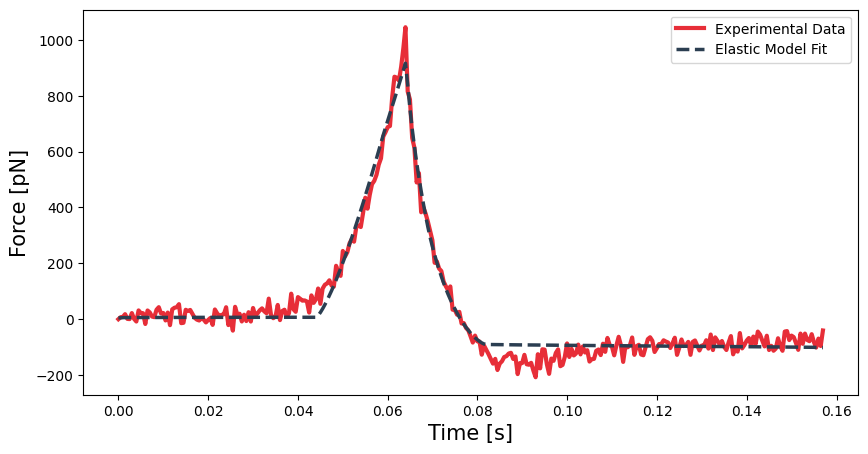

In [60]:
plt.plot(
    time_fit[idxDown] - time_fit[idxDown][0],
    force_fit[idxDown] * 1e12,
    color='#E72E38',
    linewidth=3,
    label='Experimental Data'
)

plt.plot(
    time_fit[idxDown] - time_fit[idxDown][0],
    ting_result.eval(
        time_fit[idxDown],
        force_fit[idxDown],
        ind_fit[idxDown],
        t0=1,
        idx_tm=ting_result.idx_tm,
        smooth_w=ting_result.smooth_w,
        v0t=ting_result.v0t,
        v0r=ting_result.v0r) * 1e12,
    color='#2B3E51',
    linewidth=2.5,
    linestyle='--',
    label='Elastic Model Fit'
)
plt.xlabel('Time [s]', fontsize = 15)
plt.ylabel('Force [pN]', fontsize = 15)
plt.legend()
plt.show()